In [1]:
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
##################################################
# Question a
##################################################

# location of file
filename = 'C:/Users/fabio/Desktop/Online Retail.csv'

# Load the data with limited rows for faster processing
dataset = read_csv(filename, encoding='windows-1254')

# Display the first few rows to understand the dataset
print(dataset.head(), "\n")

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom   



In [3]:
# Data preprocessing: adding a TotalPrice column
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']

# Aggregating the data by CustomerID to get the total quantity and total price for each customer
customer_data = dataset.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

# Feature scaling
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(customer_data[['Quantity', 'TotalPrice']])


# Function to calculate silhouette scores for k-means with clusters between 2 and 8
silhouette_scores = []
range_n_clusters = range(2, 9)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_dataset)
    silhouette_avg = silhouette_score(scaled_dataset, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
# Silhouette scores for k-means with clusters between 2 and 8
print("Silhouette_scores:", silhouette_scores)

Silhouette_scores: [np.float64(0.9830044706552725), np.float64(0.9561031477840037), np.float64(0.9314275129237506), np.float64(0.8155049239902049), np.float64(0.8054488993304987), np.float64(0.7187161900187621), np.float64(0.7186826301815898)]


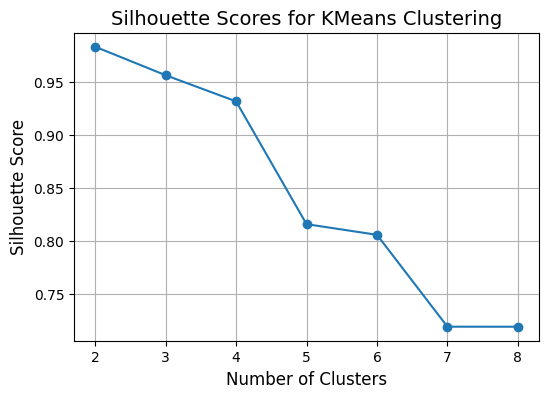

In [4]:
# Plotting the silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans Clustering', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.show()

In [5]:
# Determine the 2 best values for the number of clusters
best_clusters = np.argsort(silhouette_scores)[-2:] + 2  # Adding 2 because of 0-indexing
print("The best two clusters are", best_clusters)

The best two clusters are [3 2]


In [6]:
##################################################
# Question b
##################################################

# Function for plotting the centroids for the clusters
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
# Function for plotting the Voronoi diagram for the clusters
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

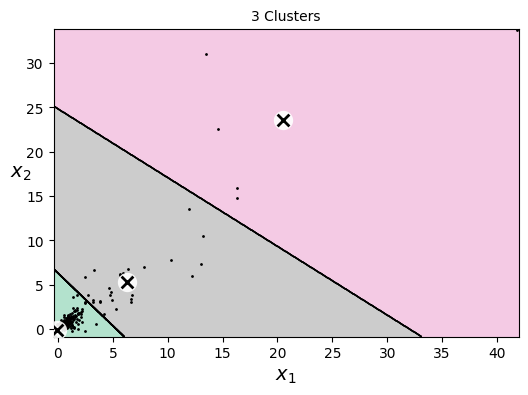

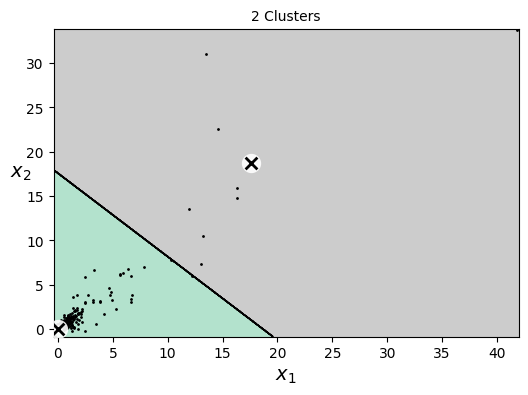

In [7]:
# Function for plotting the best two clusters
for i in best_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(scaled_dataset)
    kmeans.cluster_centers_
    plt.figure(figsize=(6, 4))
    plot_decision_boundaries(kmeans, scaled_dataset)
    title = str(i) + ' Clusters'
    plt.title(title, fontsize=10)
    plt.show()

In [16]:
from sklearn.cluster import MiniBatchKMeans

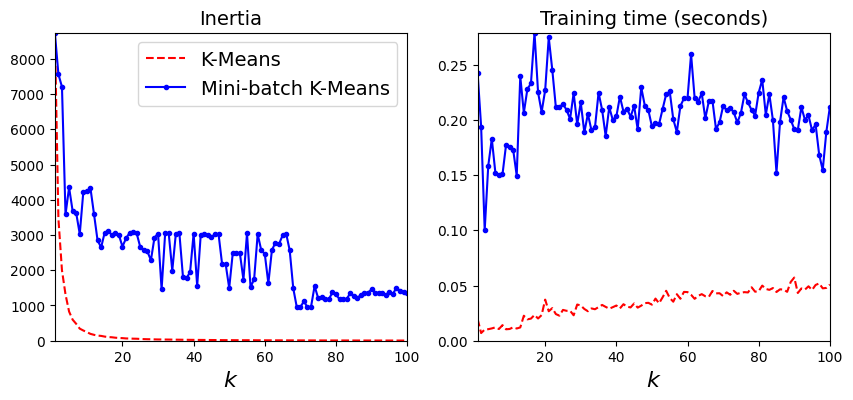

In [29]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt

# Ensure scaled_dataset is already defined
X = scaled_dataset
k_values = range(2, 10)  # Testing silhouette scores for k from 2 to 9

# Store inertia and time results for both K-Means and Mini-Batch K-Means
times = np.empty((100, 2))   # 100 rows for k = 1 to 100, 2 columns (K-Means, Mini-Batch K-Means)
inertias = np.empty((100, 2))

for k in range(1, 101):  # Running K-means and Mini-batch K-means for k = 1 to 100
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    
    # Measure time taken for K-Means and Mini-Batch K-Means (run once for each)
    times[k-1, 0] = timeit(lambda: kmeans_.fit(scaled_dataset), number=1)
    times[k-1, 1] = timeit(lambda: minibatch_kmeans.fit(scaled_dataset), number=1)
    
    # Store inertia
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

# Plotting the graphs for inertia and time comparison
plt.figure(figsize=(10,4))

# Subplot for inertia
plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, max(inertias[:, 0].max(), inertias[:, 1].max())])

# Subplot for time
plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, times[:, 1].max()])

plt.show()


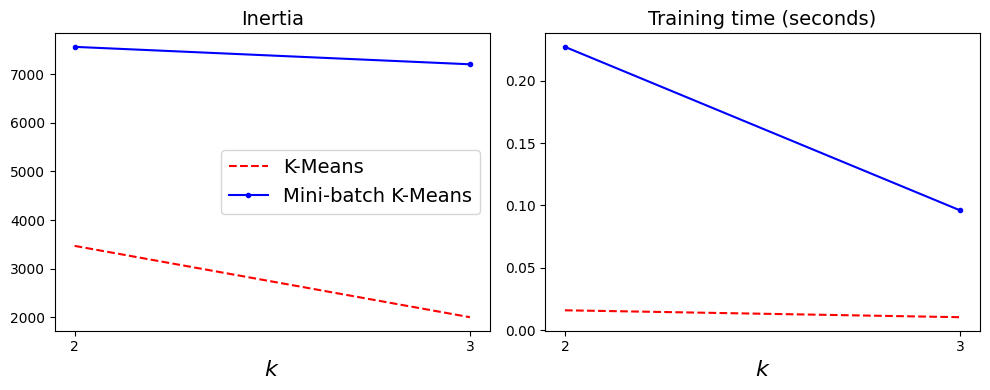

In [31]:
# Ensure scaled_dataset is already defined
X = scaled_dataset

clusters = [2, 3]  # Best cluster values based on Silhouette
times = np.empty((len(clusters), 2))   # Adjusted for only 2 clusters
inertias = np.empty((len(clusters), 2))

for i, k in enumerate(clusters):  # Using the predefined clusters
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)

    # Measure time taken for K-Means and Mini-Batch K-Means
    times[i, 0] = timeit(lambda: kmeans_.fit(X), number=1)
    times[i, 1] = timeit(lambda: minibatch_kmeans.fit(X), number=1)
    
    # Store inertia
    inertias[i, 0] = kmeans_.inertia_
    inertias[i, 1] = minibatch_kmeans.inertia_

    # Assuming 'times' and 'inertias' are already defined for clusters [2, 3]

plt.figure(figsize=(10, 4))

# Subplot for inertia
plt.subplot(121)
plt.plot(clusters, inertias[:, 0], "r--", label="K-Means")
plt.plot(clusters, inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.xticks(clusters)  # Set x-ticks to show only cluster values 2 and 3
plt.legend(fontsize=14)

# Subplot for time
plt.subplot(122)
plt.plot(clusters, times[:, 0], "r--", label="K-Means")
plt.plot(clusters, times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.xticks(clusters)  # Set x-ticks to show only cluster values 2 and 3

plt.tight_layout()  # Adjust layout for better appearance
plt.show()



In [10]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Function to evaluate clustering results
def evaluate_clustering(true_labels, cluster_labels, method_name):
    correlation_matrix = np.corrcoef(true_labels.T)
    ch_index = calinski_harabasz_score(scaled_dataset, cluster_labels)
    db_index = davies_bouldin_score(scaled_dataset, cluster_labels)
    
    print(f"Evaluation Metrics for {method_name}:")
    print("Correlation Matrix:\n", correlation_matrix)
    print("Calinski-Harabasz Index:", ch_index)
    print("Davies-Bouldin Index:", db_index)
    print("\n")

# Evaluate K-Means and Mini-Batch K-Means for the best two clusters
for i in best_two_clusters:
    # K-Means evaluation
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_dataset)
    evaluate_clustering(scaled_dataset, kmeans_labels, f'K-Means with {i} Clusters')
    
    # Mini-Batch K-Means evaluation
    mini_kmeans = MiniBatchKMeans(n_clusters=i, batch_size=mini_batch_size, random_state=42)
    mini_kmeans_labels = mini_kmeans.fit_predict(scaled_dataset)
    evaluate_clustering(scaled_dataset, mini_kmeans_labels, f'Mini-Batch K-Means with {i} Clusters')


Evaluation Metrics for K-Means with 2 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 6649.465459498878
Davies-Bouldin Index: 0.41365781175655486


Evaluation Metrics for Mini-Batch K-Means with 2 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 667.355715070368
Davies-Bouldin Index: 0.9898324745806896


Evaluation Metrics for K-Means with 3 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 7372.881342197374
Davies-Bouldin Index: 0.5763144742797394


Evaluation Metrics for Mini-Batch K-Means with 3 Clusters:
Correlation Matrix:
 [[1.         0.92164896]
 [0.92164896 1.        ]]
Calinski-Harabasz Index: 803.5857313442767
Davies-Bouldin Index: 1.0063116175045907


